In [1]:
%load_ext autoreload
%autoreload 2
from corr_study.datasetApi import *
from corr_study.correlation import *
from corr_study.voxels import *

dataset = Dataset("corr_study/dataset/")

route = dataset.get_routes_TLC()[0]
ids = dataset.get_ids_CV(Town.T1, Weather.Clear, Time.Night, Sensor.LT)

pcd_top = dataset.open_sample_CV(Town.T1, Weather.Clear, Time.Night, Sensor.LT, ids[0]) 
pcd_front_left = dataset.open_sample_CV(Town.T1, Weather.Clear, Time.Night, Sensor.LFL, ids[0]) 
pcd_front_rigth = dataset.open_sample_CV(Town.T1, Weather.Clear, Time.Night, Sensor.LFR, ids[0]) 
cam_front = dataset.open_measurement_sample_TLC(route, Weather.Clear, Time.Noon, Sensor.CF, 10)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


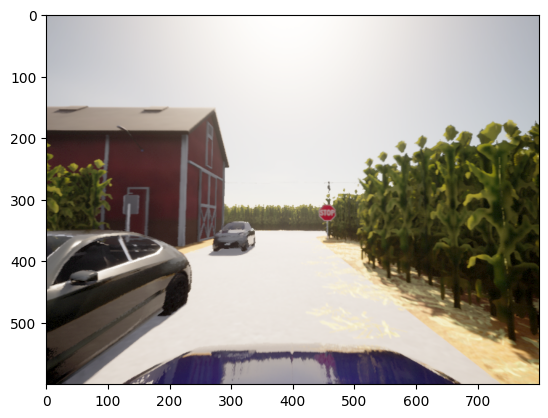

In [2]:
cam_front.visualize()
pcd_top.visualize()

In [3]:
voxel_size = .25

v_top = pcd_top.voxelize(voxel_size)
v_fl = pcd_front_left.voxelize(voxel_size, boundaries=v_top.boundaries)
print("Correlation:",v_top.compute_correlation(v_fl))
print("Correlation with allignement:", v_top.compute_correlation_inferring_offset(v_fl))

Correlation: 0.009751331980558562
Correlation with allignement: 0.19667207702176454


In [4]:
v_top_cum = pcd_top.voxelize(voxel_size, cumulative=True)
v_fl_cum = pcd_front_left.voxelize(voxel_size, boundaries=v_top.boundaries, cumulative=True)
print("Correlation:",v_top_cum.compute_correlation(v_fl_cum))
print("Correlation with allignement:", v_top_cum.compute_correlation_inferring_offset(v_fl_cum))

Correlation: 0.0004168816238237623
Correlation with allignement: 0.40613254203754934


In [6]:
pcd_top_1 = dataset.open_sample_CV(Town.T1, Weather.Clear, Time.Night, Sensor.LT, ids[0]) 
pcd_top_2 = dataset.open_sample_CV(Town.T1, Weather.Clear, Time.Night, Sensor.LT, ids[123]) 
# pcd_top_1.visualize()
# pcd_top_2.visualize()
v_top_1 = pcd_top_1.voxelize(voxel_size)
v_top_2 = pcd_top_2.voxelize(voxel_size, boundaries=v_top_1.boundaries)
print(v_top_1.compute_correlation(v_top_2))
print(v_top_1.compute_correlation_inferring_offset(v_top_2))

0.13544428435556125
0.13544428435556125


In [7]:
v_top_1_cum = pcd_top_1.voxelize(voxel_size, cumulative=True)
v_top_2_cum = pcd_top_2.voxelize(voxel_size, boundaries=v_top_1.boundaries, cumulative=True)
print(v_top_1_cum.compute_correlation(v_top_2_cum))
print(v_top_1_cum.compute_correlation_inferring_offset(v_top_2_cum))

0.9724143371441519
0.9724143371441519
